# Non-Linear Least Squares

We're now going to approach estimation with a non-linear state to measurement space mapping.

$
y  = h(x) + v
$

where $h(x)$ is a non-linear function and $v$ is a noise vector. 

As presented in class we cannot apply recursive estimation to the problem in it's current non-linear form. However, we can *linearize* the problem, allowing application of recursive estimation:

$
h(x) \approx h(\hat{x}_t) + H_{\hat{x}_t}(x - \hat{x}_t)
$

where $H_{\hat{x}_t}$ is the Jacobian of h evaluated at $\hat{x}_t$:

This presents $h(x)$ as a linear function in the form of $Ax + b$ since $h(\hat{x}_t)$ and $H_{\hat{x}_t}$ are constant in this context. From here we can use recursive estimation the same as before. Note the *linearization* is only useful if $x$ is near $\hat{x}_t$, otherwise the approximation quickly breaks down. This is why it's important to update the Jacobian frequently. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

%matplotlib inline

We'll define $h(x)$ as:


$h(x) = (f_{range}(x), f_{bearing}(x))$

where 

$
f_{range}(x) = sqrt({x_1}^2 + {x_2}^2) \\
f_{bearing}(x) = atan2(x_2, x_1)
$

In [2]:
# TODO: complete implementation
def f_range(x):
    """
    Distance of x from the origin.
    """
    return LA.norm(x)

# TODO: complete implementation
def f_bearing(x):
    """
    atan2(x_2, x_1)
    """
    return np.arctan2(x[1], x[0])

def h(x):
    return np.array([f_range(x), f_bearing(x)])

### Linearize $h(x)$

In order to linearize $h(x)$ you'll need the Jacobian:

$
\begin{bmatrix}
\frac{\partial{f_{range}}}{\partial{x_1}} & \frac{\partial{f_{range}}}{\partial{x_2}} \\
\frac{\partial{f_{bearing}}}{\partial{x_1}} & \frac{\partial{f_{bearing}}}{\partial{x_2}} \\
\end{bmatrix}
$

Remember to swap the derivative results of atan2 to match the swapped inputs ($atan2(x, y)$ vs $atan2(y, x)$).

Jacobian solution:

$
\begin{bmatrix}
\frac{1}{2}(x_1^2 + x_2^2)^{\frac{-1}{2}} * 2x_1 & \frac{1}{2}(x_1^2 + x_2^2)^{\frac{-1}{2}} * 2x_2 \\
\frac{-x_1}{x_1^2 + x_2^2} & \frac{x_2} {x_1^2 + x_2^2} \\
\end{bmatrix}
$

In [3]:
# TODO: complete jacobian of h(x)
def jacobian_of_h(x):
    t = (1/2) * (x[0]**2 + x[1]**2) ** (-1/2)
    return np.array([        
        [t*2*x[0], t*2*x[1]],
        
        # atan2(x, y)
        # ( y / (x^2 + y^2), ( -x / (x^2 + y^2)
        # atan2(x, y)
        # ( -x / (x^2 + y^2), ( $y / (x^2 + y^2)
        [-x[0] / (x[0]**2 + x[1]**2), x[1] / (x[0]**2 + x[1]**2)]
    ]).squeeze()

Awesome! With the Jacobian of $h$ in your toolbox, you can plug it into recursive estimation.

The update functions should look familiar ($H_{\hat{x}_t}$ is the Jacobian of $\hat{x}_t$).

$
Q_{t+1} = (Q_{t}^{-1} + H_{\hat{x}_t}^T R^{-1} H_{\hat{x}_t})^{-1} \\
\hat{x_{t+1}} = \hat{x_t} + Q_{t+1} H_{\hat{x}_t}^{T} R^{-1} (\tilde{y_t} -  h(\hat{x_t}))
$

### Setup

In [4]:
n_samples = 1000

# Covariance matrix
# added noise for range and bearing functions
#
# NOTE: these are set to low variance values
# to start with, if you increase them you
# might more samples to get
# a good estimate.
R = np.eye(2)
R[0, 0] = 0.01
R[1, 1] = np.radians(1) 

# ground truth state
x = np.array([1.5, 1])

Initialize $\hat{x}_0$ and $Q_0$.

In [5]:
x_hat0 = np.array([3., 3]).reshape(-1, 1)
Q0 = np.eye(len(x_hat0))

In [6]:
# TODO: Recursive Estimation
def recursive_estimation(x_hat0, Q0, n_samples):
    x_hat = np.copy(x_hat0)
    Q = np.copy(Q0)

    for _ in range(n_samples):

        # TODO: sample a measurement
        y_obs = h(x) + np.random.multivariate_normal([0, 0], R)

        # TODO: compute the jacobian of h(x_hat)
        H = jacobian_of_h(x_hat)

        # TODO: update Q and x_hat
        Q = LA.pinv(LA.pinv(Q) + H.T @ LA.pinv(R) @ H)
        x_hat = x_hat + (Q @ H.T @ LA.pinv(R) @ (y_obs - h(x_hat))).reshape(2, 1)
        
    return x_hat, Q

In [7]:
print("x̂0 =", x_hat0.squeeze())

x_hat, Q = recursive_estimation(x_hat0, Q0, n_samples)
    
print("x =", x.squeeze())
print("x̂ =", x_hat.squeeze())
print("Hx =", h(x))
print("Hx̂ =", h(x_hat))

x̂0 = [ 3.  3.]
x = [ 1.5  1. ]
x̂ = [ 1.50887357  1.00103609]
Hx = [ 1.80277564  0.5880026 ]
Hx̂ = [ 1.81073817  0.58576037]


### Error Curve

Text(0,0.5,'Error')

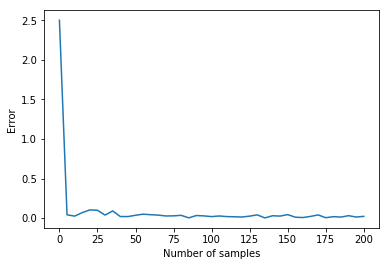

In [8]:
errors = []
Ns = np.arange(0, 201, 5)
for n in Ns:
    x_hat, Q = recursive_estimation(x_hat0, Q0, n)
    errors.append(LA.norm(x.squeeze() - x_hat.squeeze()))

plt.plot(Ns, errors)
plt.xlabel('Number of samples')
plt.ylabel('Error')